In [9]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
import collections
from sklearn.model_selection import cross_val_score

warnings.filterwarnings(action='ignore')

PATH = '../data/'

def make_days(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    return (dt.date(year, month, day) - dt.date(2020, 10, 31)).days

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^\-0-9\.]+", '', str(x))
    if x =='':
        return -1
    else:
        return int(float(x))

In [3]:
# 문자열(ex "1,000")로 되어있는 퀄리티 데이터 float 타입으로 변환
train_quality = pd.read_csv(PATH+'train_quality_data.csv')
for i in range(0,13,1):
    train_quality['quality_' + str(i)] = train_quality['quality_' + str(i)].apply(lambda x: string2num(x)).astype(float)
train_quality['days'] = train_quality['time'].apply(make_days)

test_quality = pd.read_csv(PATH+'test_quality_data.csv')
for i in range(0,13,1):
    test_quality['quality_' + str(i)] = test_quality['quality_' + str(i)].apply(lambda x: string2num(x)).astype(float)
test_quality['days'] = test_quality['time'].apply(make_days)

In [4]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 

# 펌웨어 버전별 데이터 개수 및 불만 접수 확률

In [10]:
fwver_list = set(list(train_quality['fwver'].unique()) + list(test_quality['fwver'].unique()))
result = []
for i in fwver_list:
    a = (train_quality['fwver'] == i).sum()
    b = (test_quality['fwver'] == i).sum()
    if a > 0:
        user_ids = train_quality[train_quality['fwver'] == i]['user_id'].unique()
        _p = 0
        _np = 0
        for j in user_ids:
            if problem[j - 10000]:
                _p += 1
            else:
                _np += 1
        result.append([i, a, b, a+b, _p, _np, _p / (_p+_np)])
    else:
        result.append([i, a, b, a+b, 0, 0, 0])
        
result = pd.DataFrame(result, columns=['fwver','train_count','train_count', 'all_count', 'problem users', 'no problem users', 'p/p+np'])
result = result.sort_values('all_count', ascending=False)
result.loc[(result['problem users'] + result['no problem users']) > 50]

,fwver,train_count,train_count,all_count,problem users,no problem users,p/p+np
20,05.15.2138,163236,142704,305940,487,1237,0.282483
23,04.22.1750,142032,141912,283944,868,1099,0.441281
25,04.33.1261,131340,121584,252924,851,1101,0.435963
7,04.16.3553,111996,109056,221052,667,776,0.462231
18,03.11.1167,104148,84240,188388,111,403,0.215953
6,04.33.1185,66024,57828,123852,476,683,0.410699
10,04.22.1778,56472,59736,116208,513,588,0.465940
11,04.16.3571,2232,2172,4404,43,25,0.632353


# 펌웨어 별 퀄리티 통계
- 펌웨어 버전에 따라 존재하는 퀄리티 정보도 다르고 분포도 다름

In [11]:
temp = []
for fwver in ['05.15.2138', '04.22.1750']:
    tq = train_quality[train_quality['fwver'] == fwver]
    for i in range(0,13):
        col = 'quality_' + str(i)
        tq2 = tq[tq[col] != -1]
        temp.append([fwver, col, tq[col].min(),tq[col].mean(),tq[col].max(),tq[col].std(), tq2[col].min(),tq2[col].mean(),tq2[col].max(),tq2[col].std()])
temp = pd.DataFrame(temp, columns=['fwver', 'col', 'min', 'mean', 'max', 'std', 'min(remove-1)', 'mean(remove-1)', 'max(remove-1)', 'std(remove-1)'])
temp

,fwver,col,min,mean,max,std,min(remove-1),mean(remove-1),max(remove-1),std(remove-1)
0,05.15.2138,quality_0,-1.0,17.910338,157667.0,980.760702,0.0,22.091668,157667.0,1083.736003
1,05.15.2138,quality_1,-1.0,-0.169681,20.0,0.457032,0.0,0.013914,20.0,0.262513
2,05.15.2138,quality_2,-1.0,17.908335,157667.0,980.760735,0.0,22.089222,157667.0,1083.736049
3,05.15.2138,quality_3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
4,05.15.2138,quality_4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,05.15.2138,quality_5,-1.0,85.623251,637385.0,3516.925630,0.0,104.776814,637385.0,3886.085495
6,05.15.2138,quality_6,-1.0,4.598955,600.0,50.081603,0.0,5.836959,600.0,55.265688
7,05.15.2138,quality_7,0.0,57.360362,7199.0,487.472602,0.0,57.360362,7199.0,487.472602
8,05.15.2138,quality_8,0.0,0.136735,73.0,1.380913,0.0,0.136735,73.0,1.380913
9,05.15.2138,quality_9,0.0,217.072925,397424.0,6258.246640,0.0,217.072925,397424.0,6258.246640


# 펌웨어 버전에 대한 퀄리티 분포도
- 같은 펌웨어 버전을 쓰는 유저끼리 비교함.
- groupby(user_id)를 통해 각 퀄리티 컬럼의 min, mean, max, std, var, cv 값을 구함
- 해당 값을 그래프에 찍어서 분포 확인

**여기서 확실하게 problem /no problem이 구분되는 경우 해당 그래프를 feature로 활용할 수 있음**
- 예시: '05.15.2138_quality5_max': 해당 유저에 대해 05.15.2138 펌웨어 정보로 찍힌 quality5 컬럼의 max값

여기부터 05.15.2138


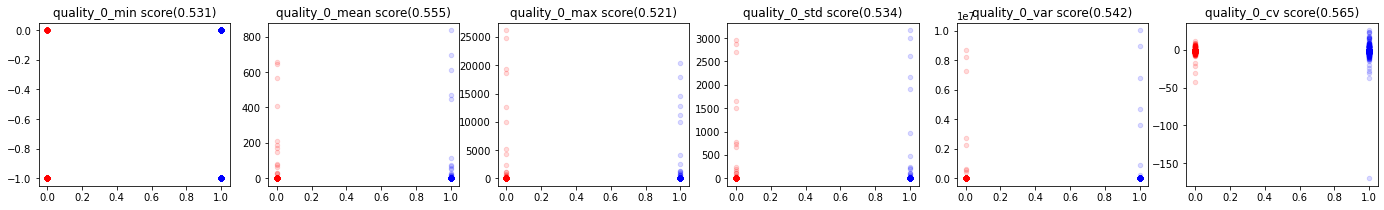

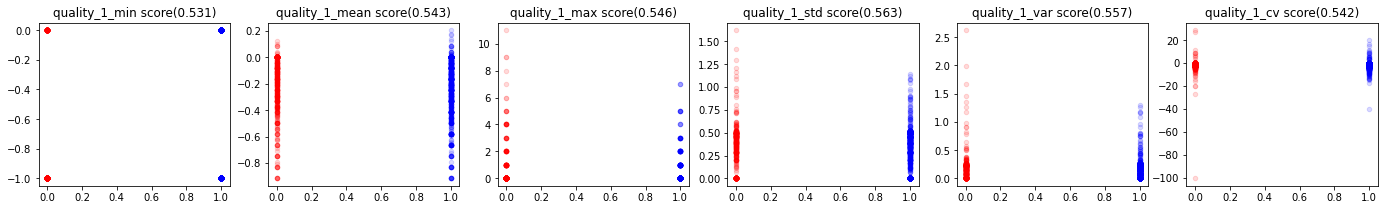

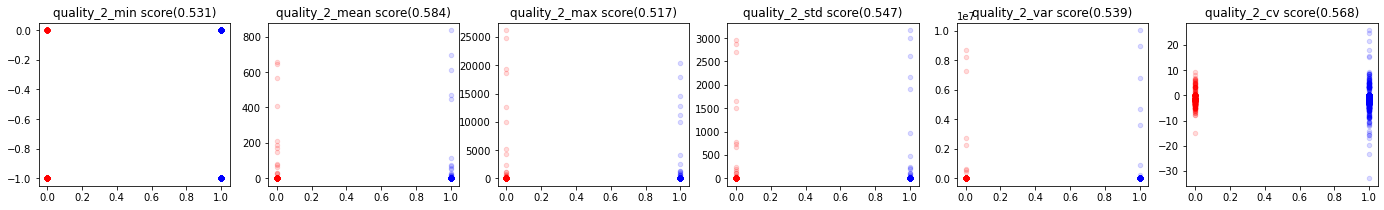

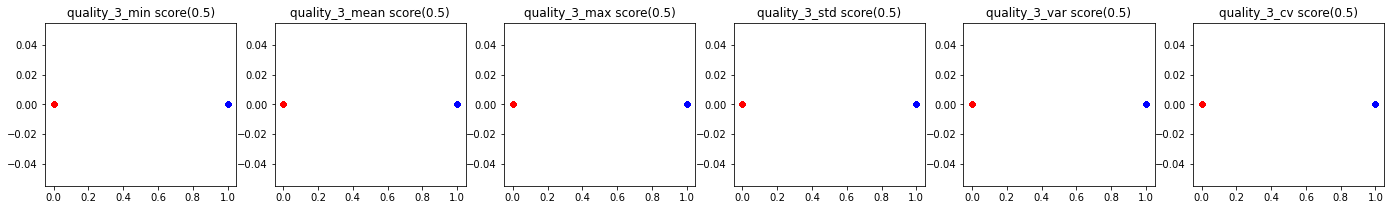

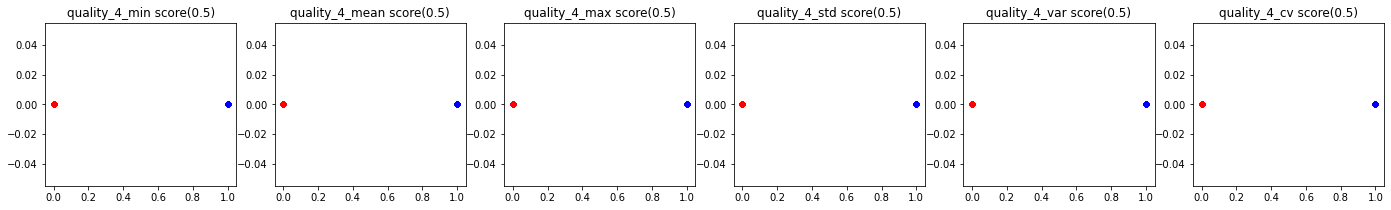

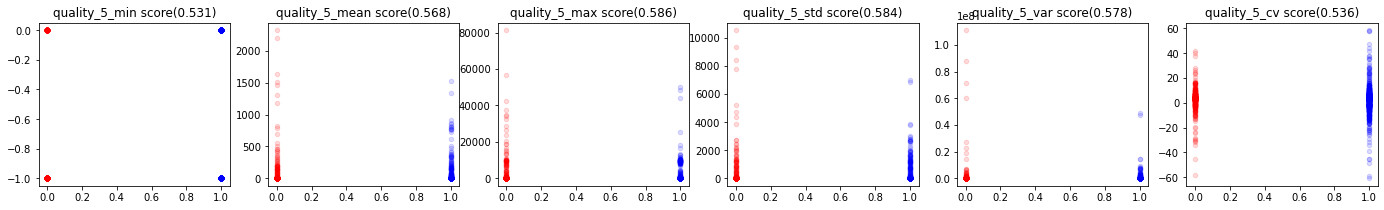

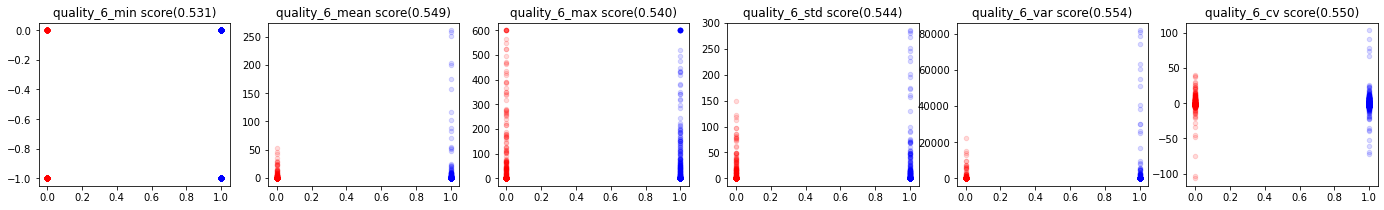

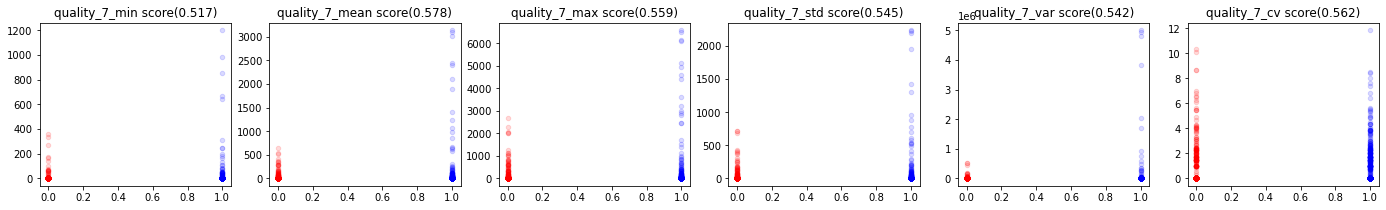

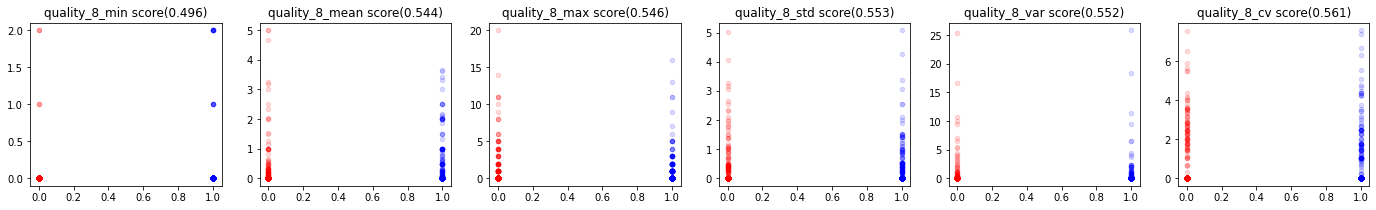

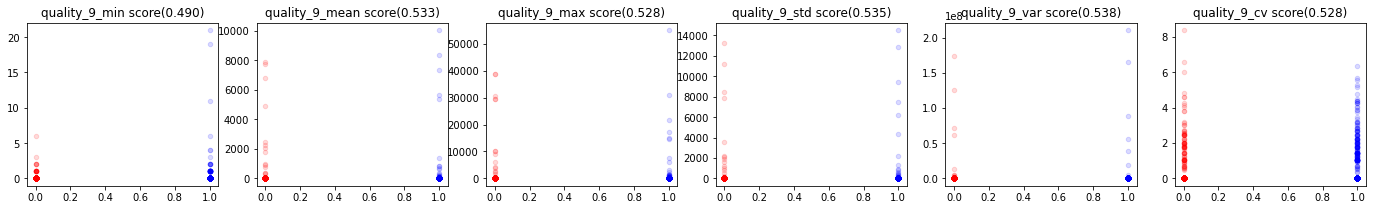

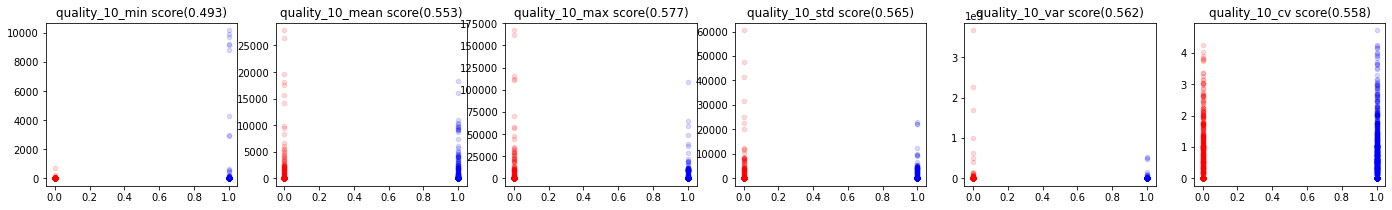

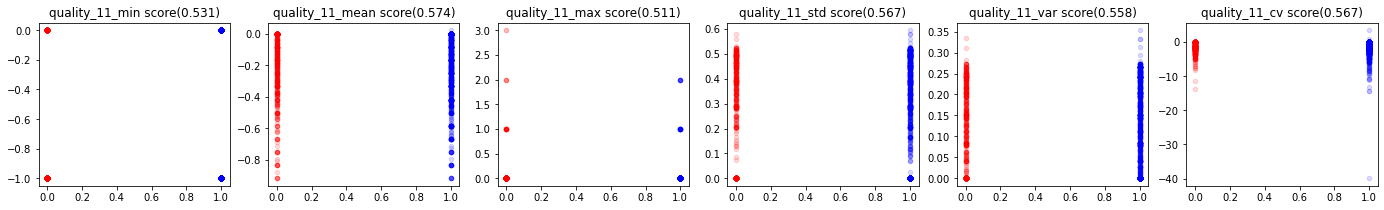

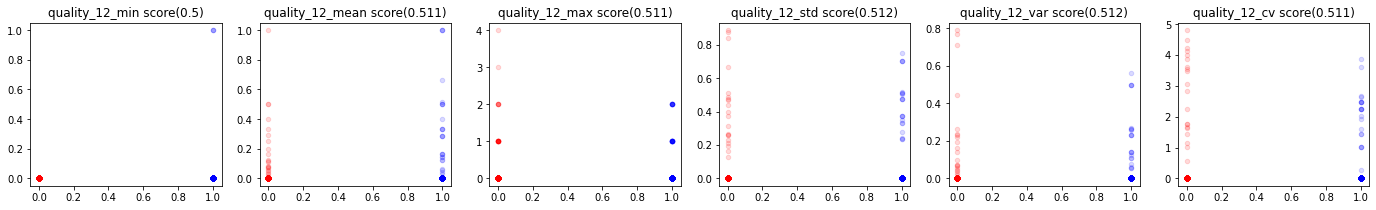

여기부터 04.22.1750


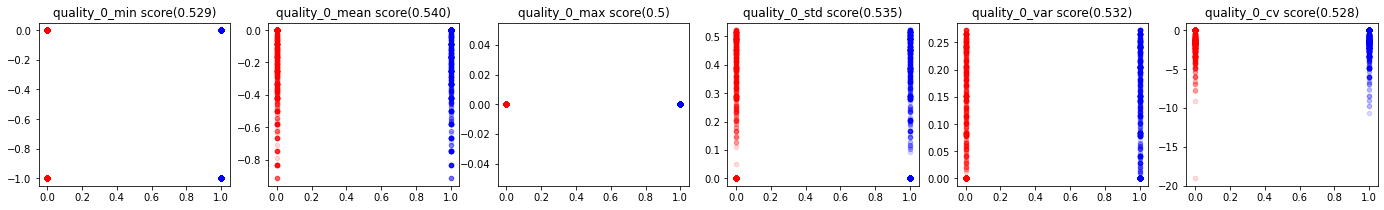

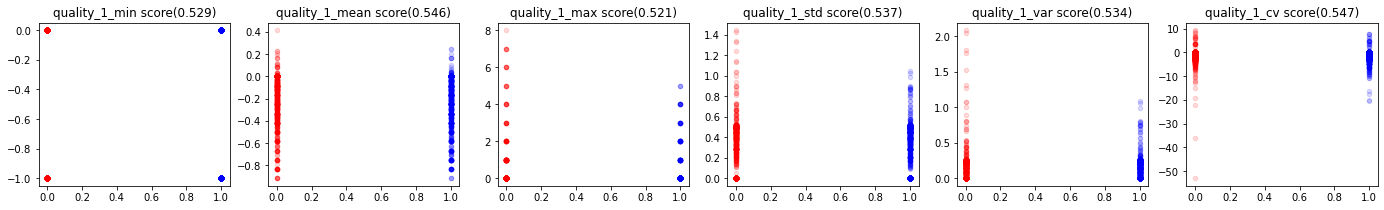

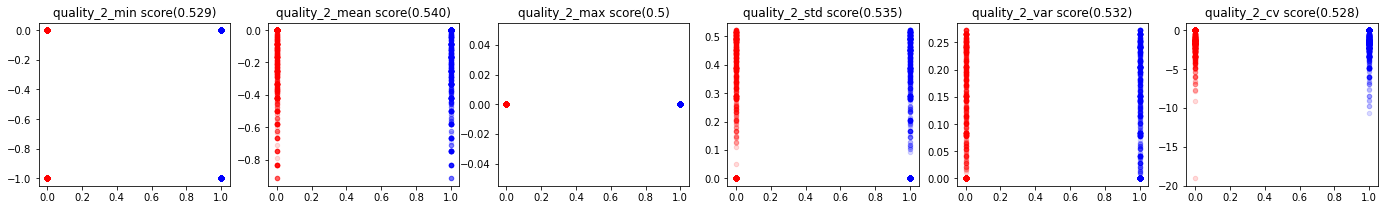

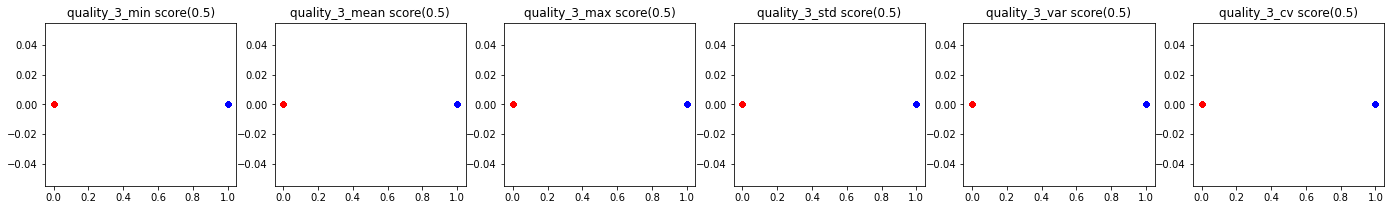

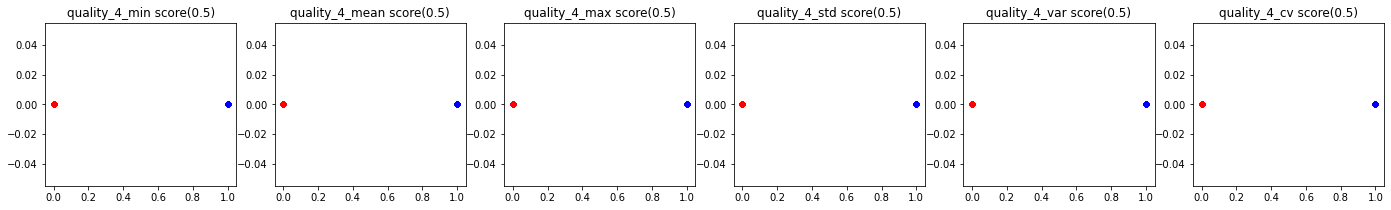

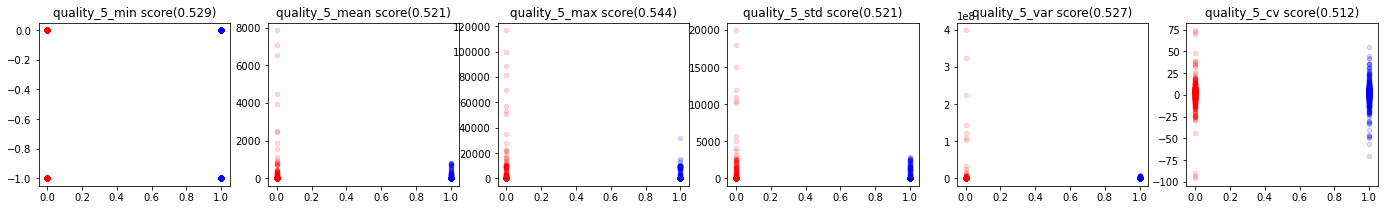

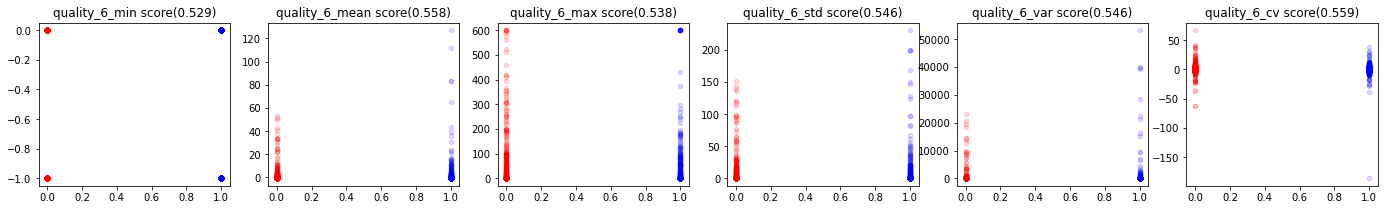

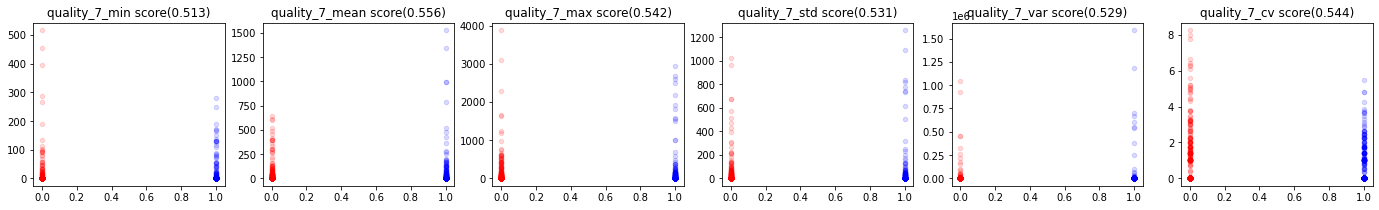

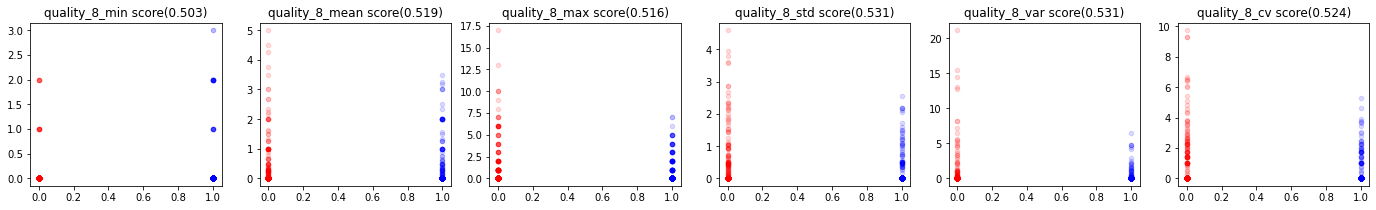

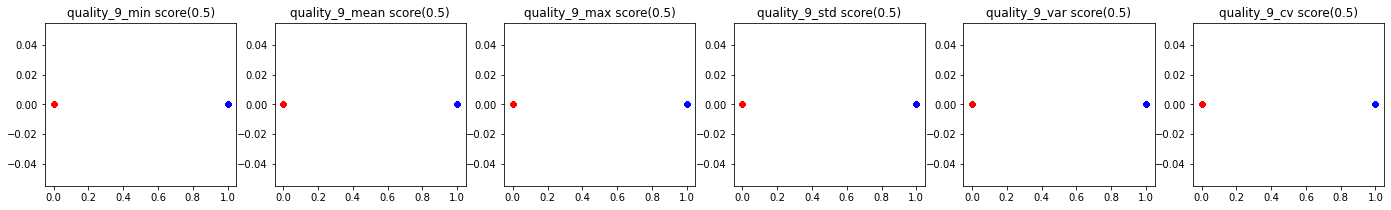

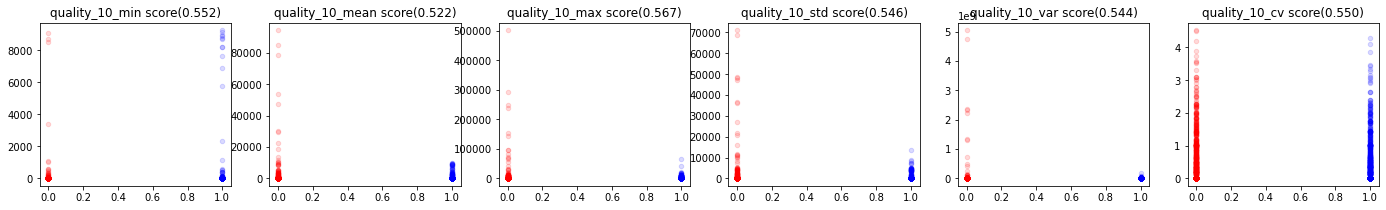

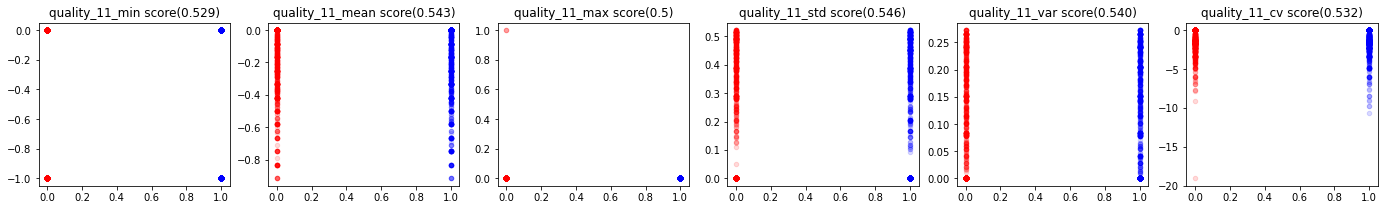

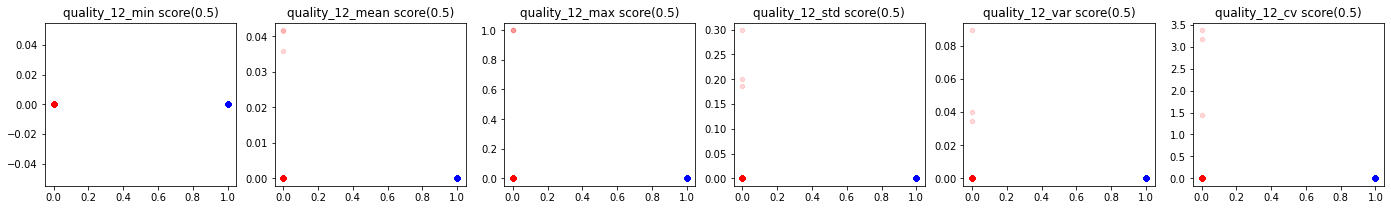

여기부터 04.33.1261


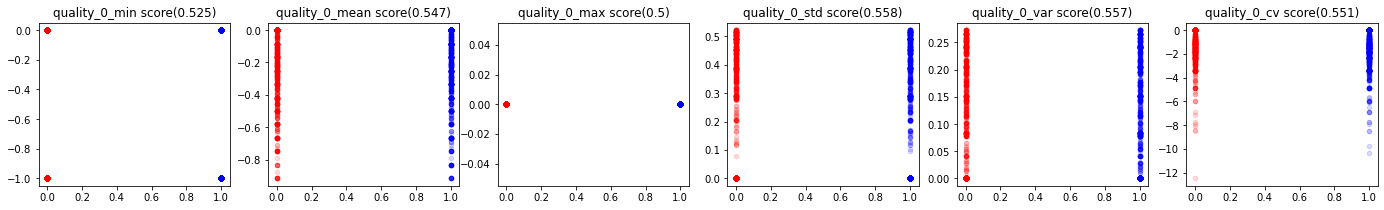

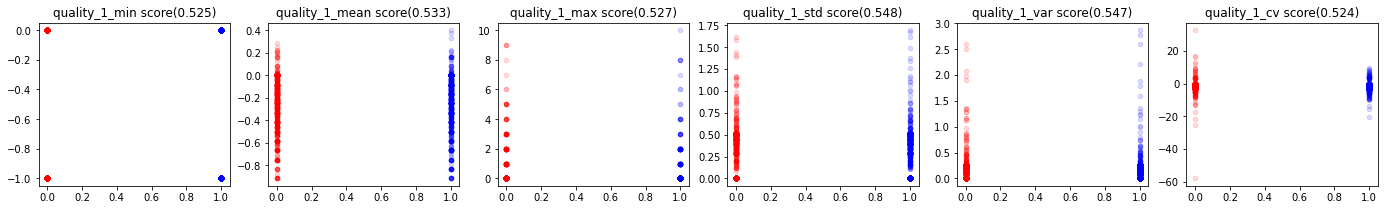

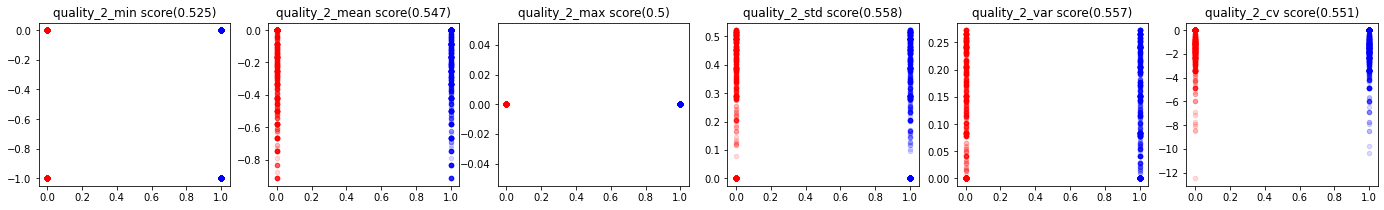

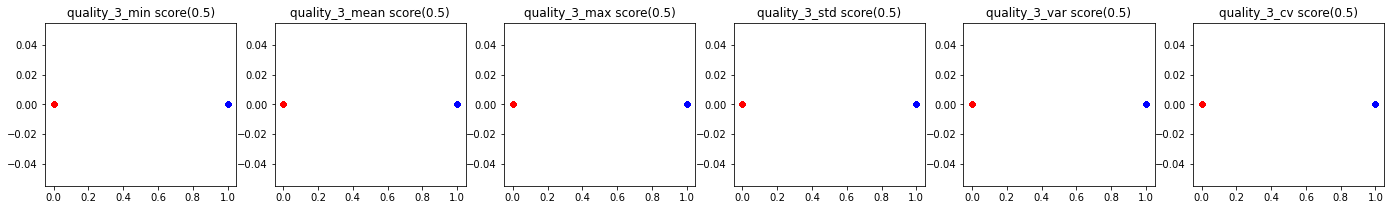

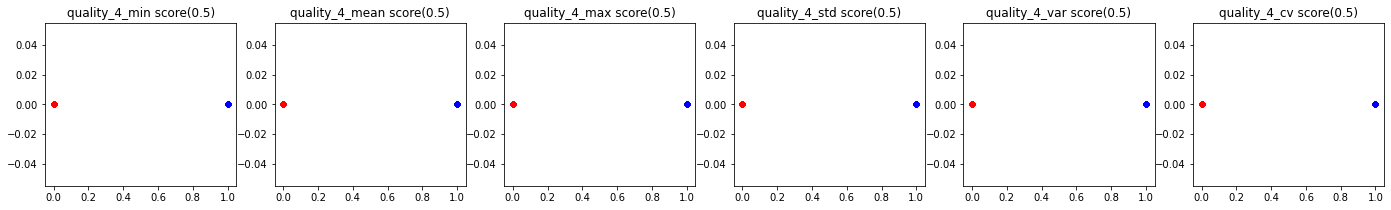

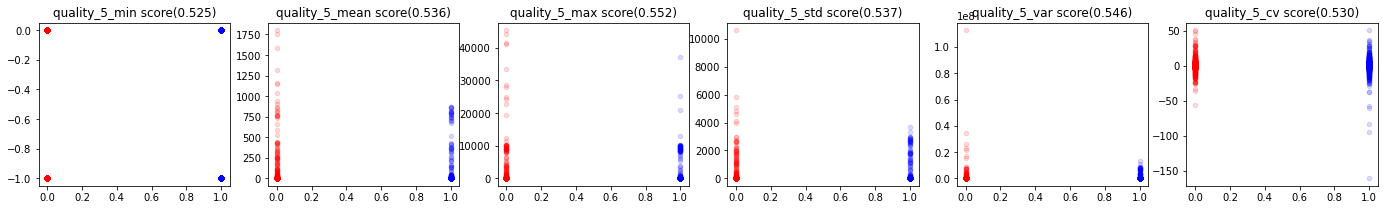

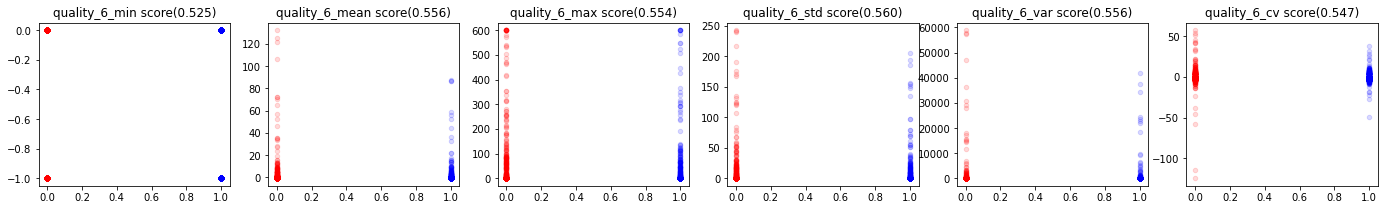

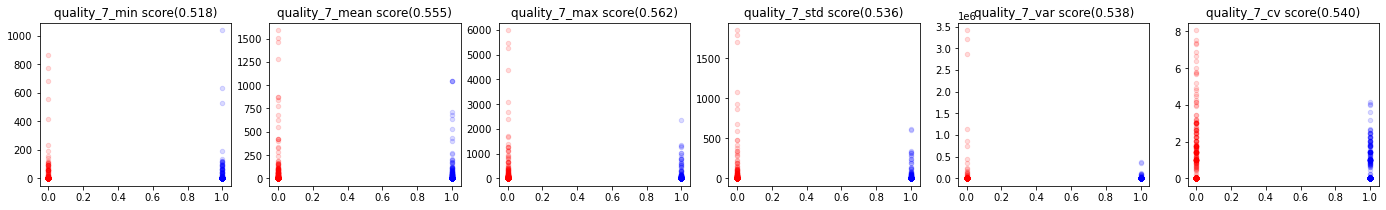

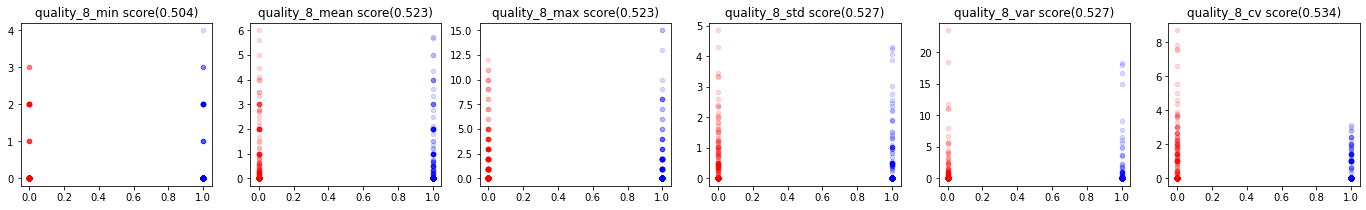

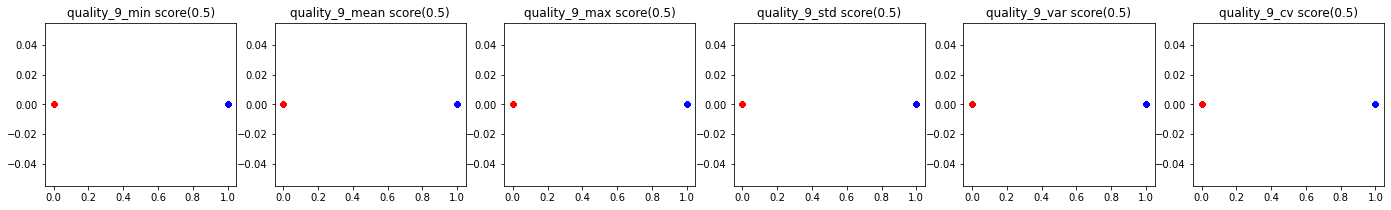

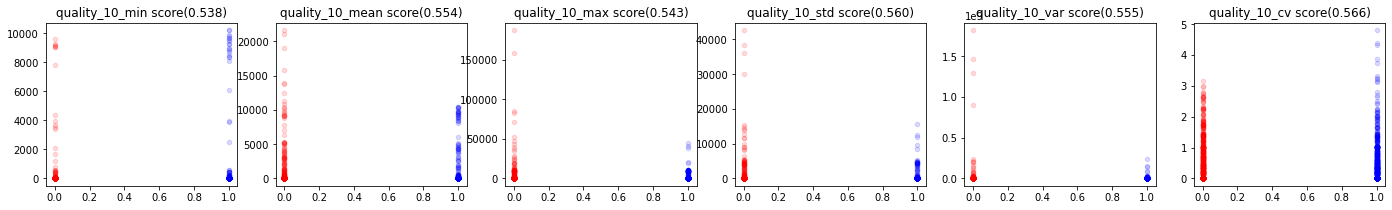

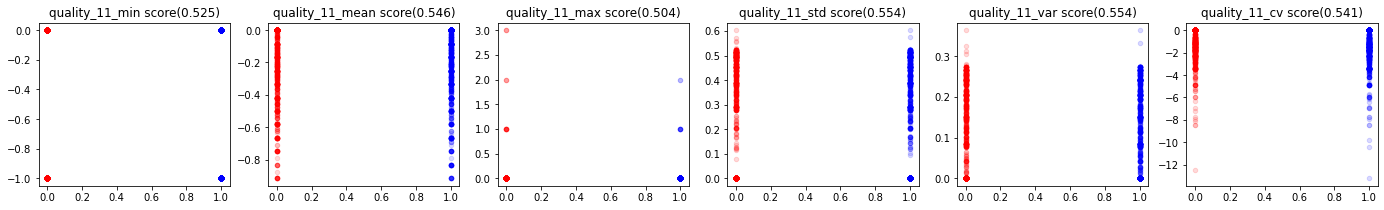

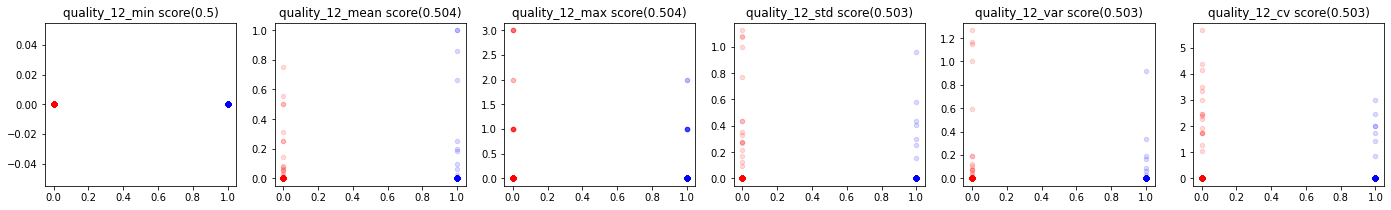

여기부터 04.16.3553


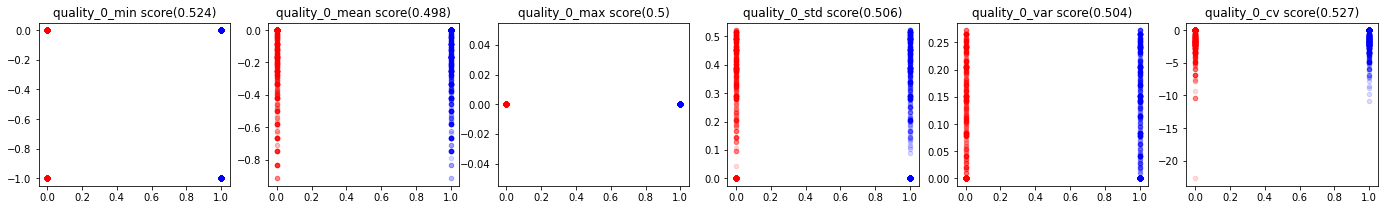

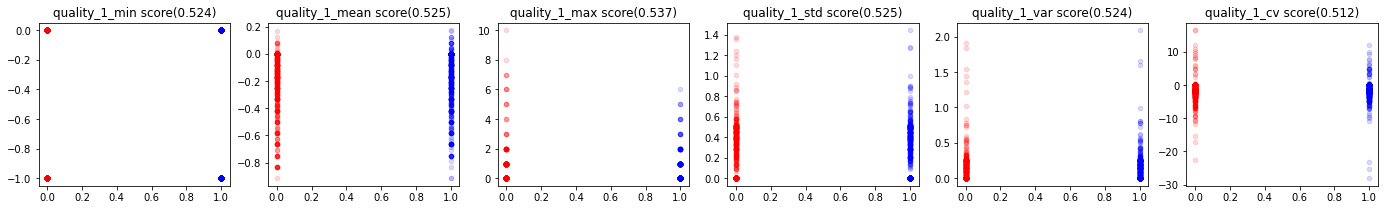

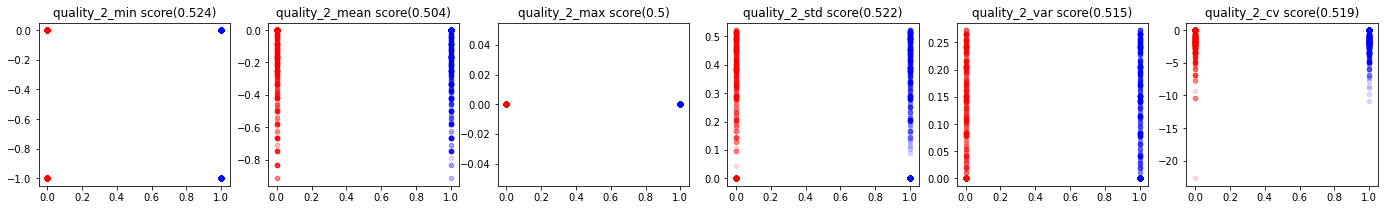

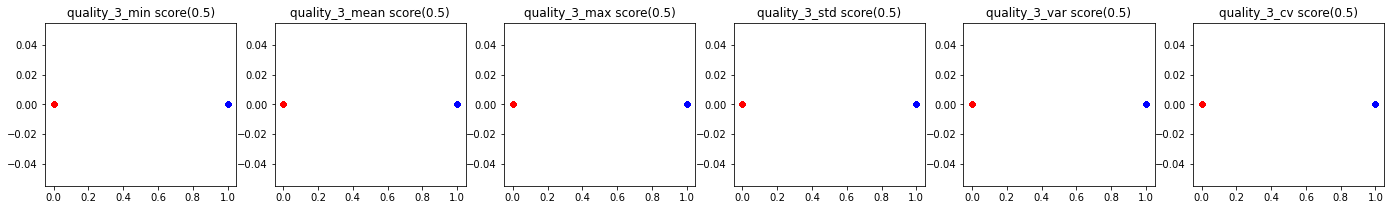

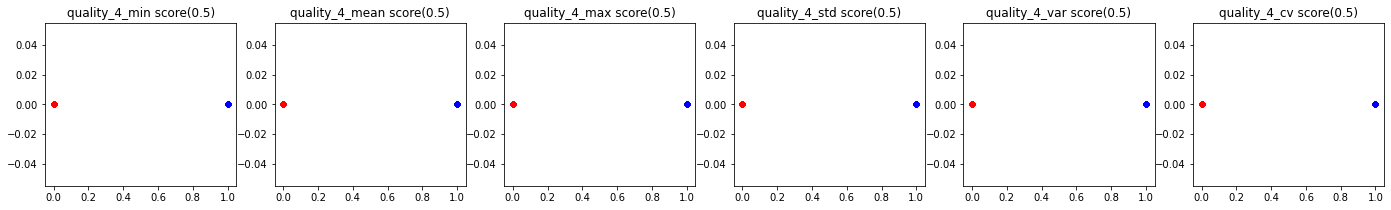

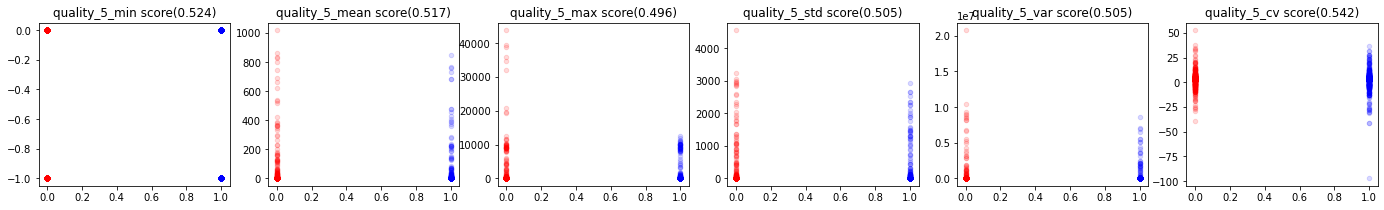

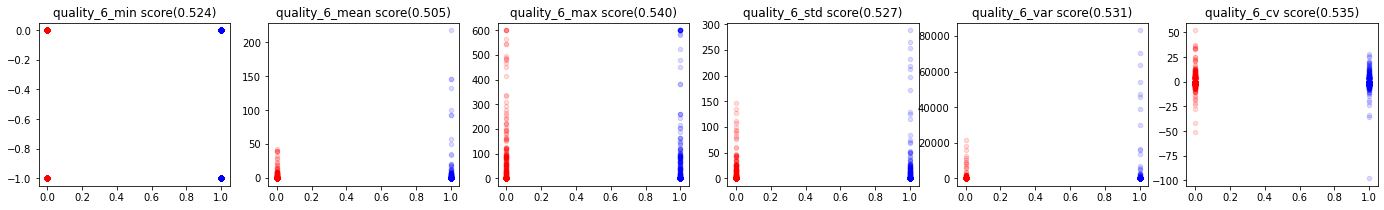

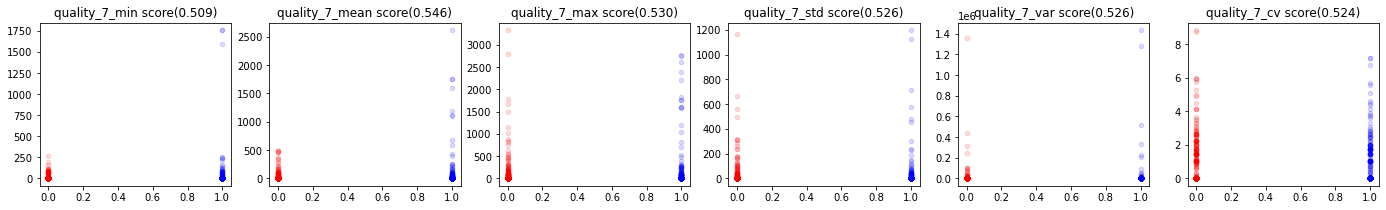

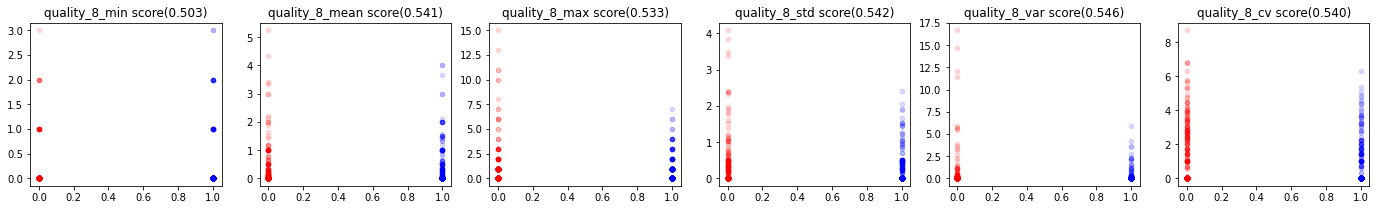

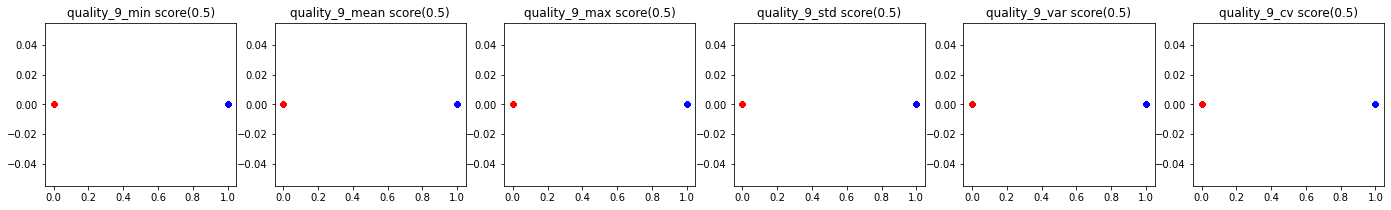

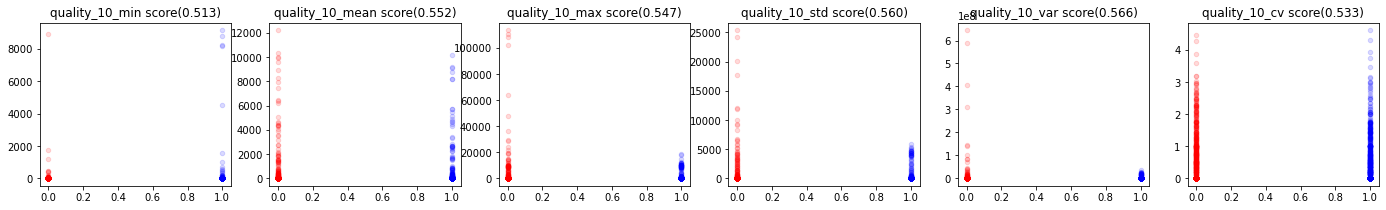

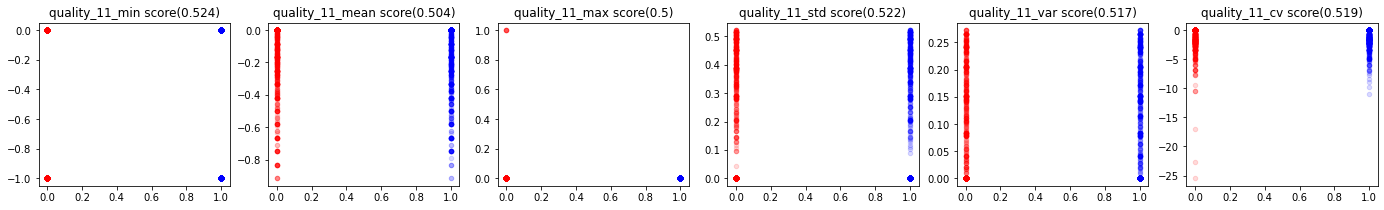

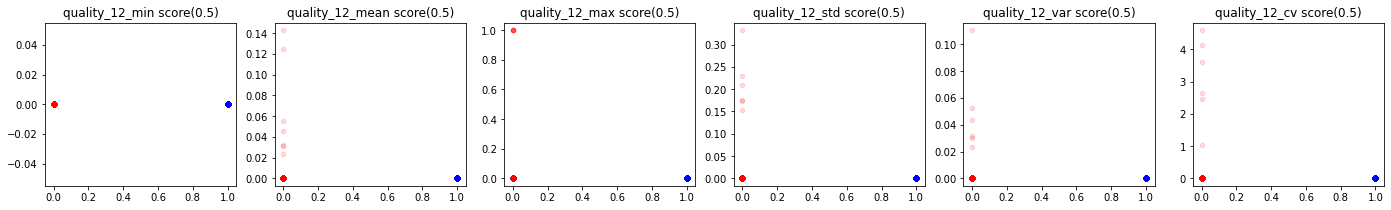

여기부터 03.11.1167


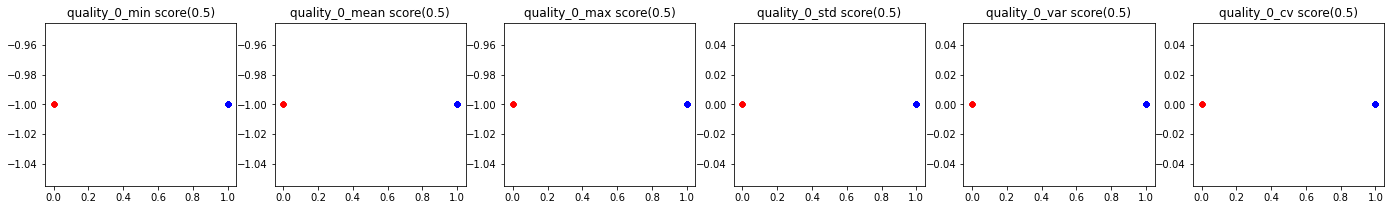

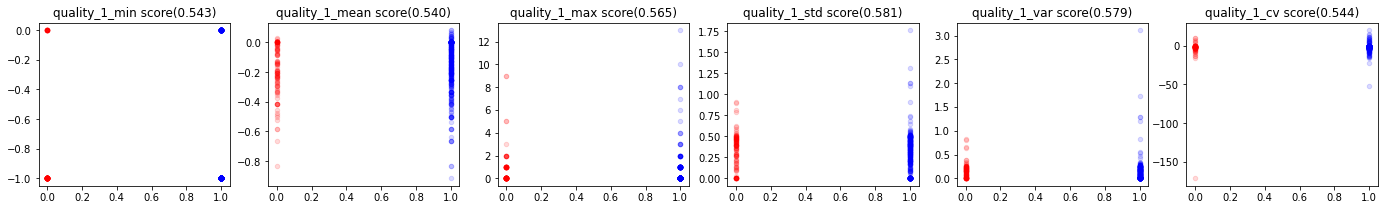

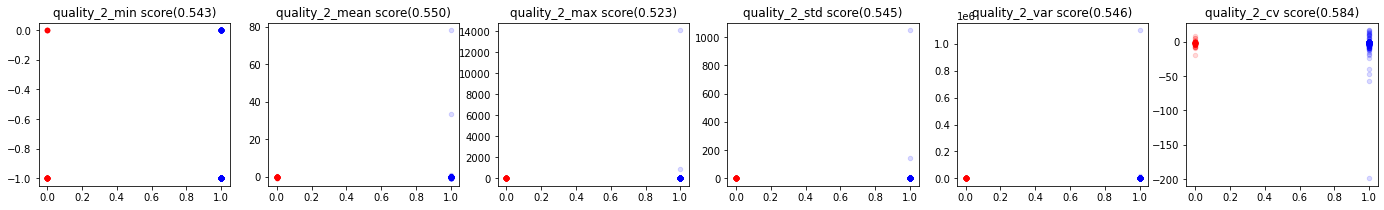

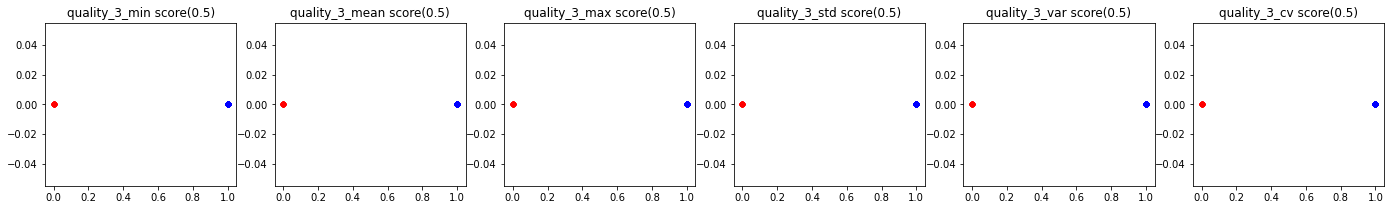

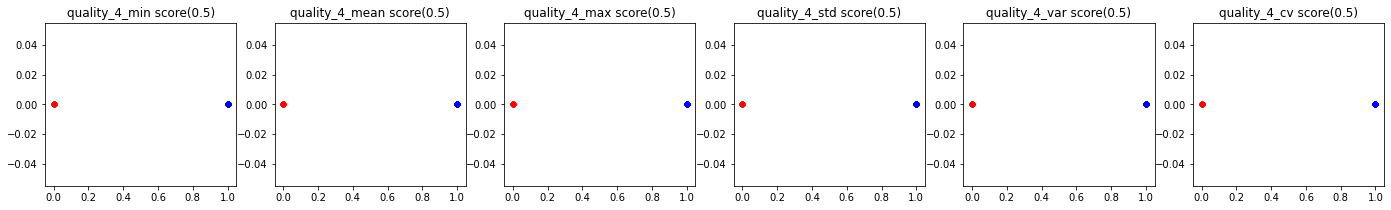

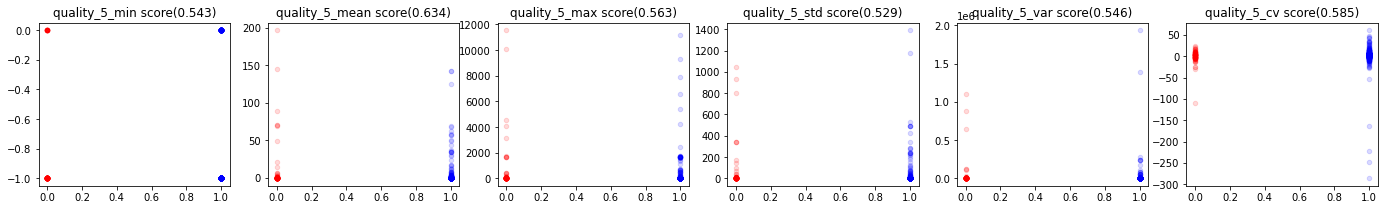

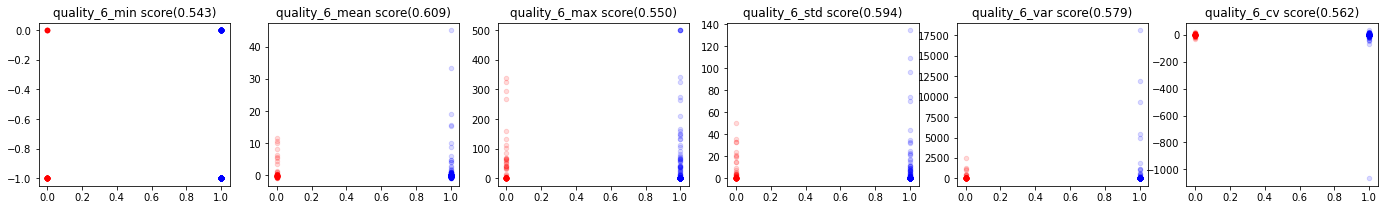

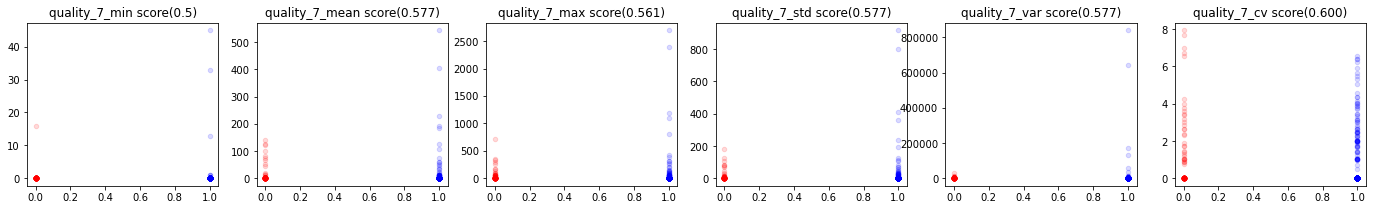

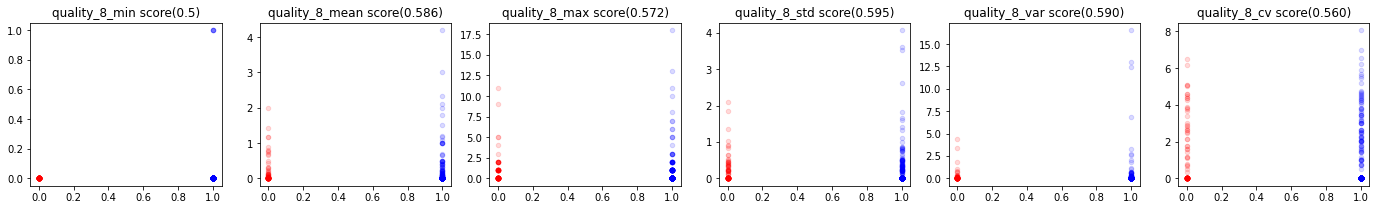

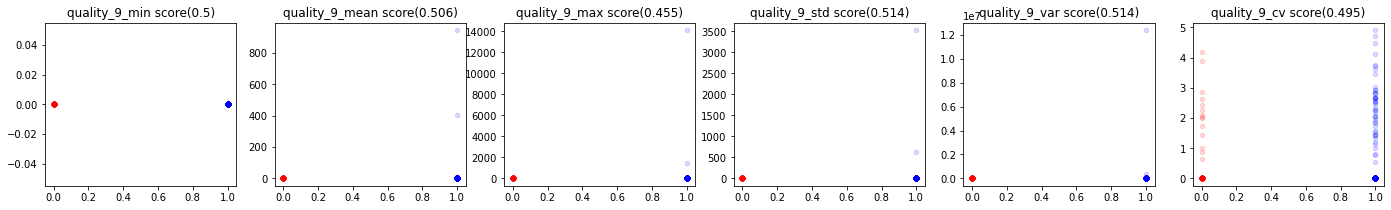

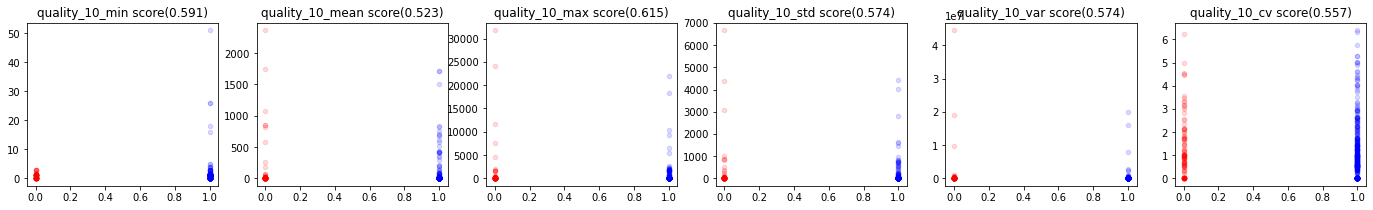

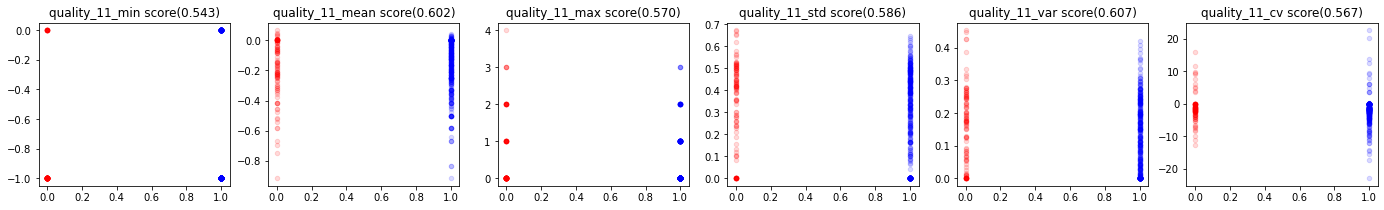

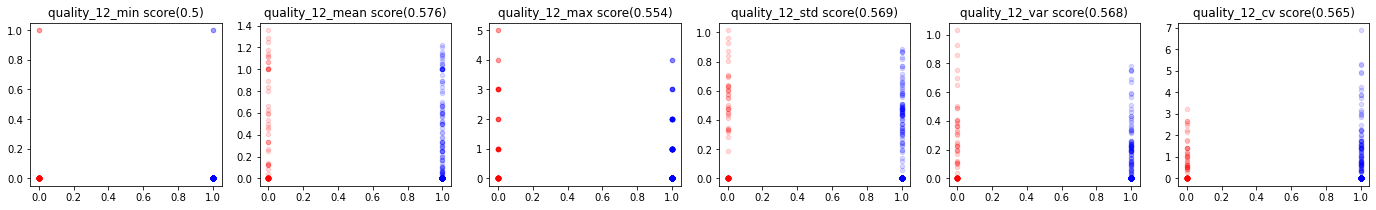

여기부터 04.33.1185


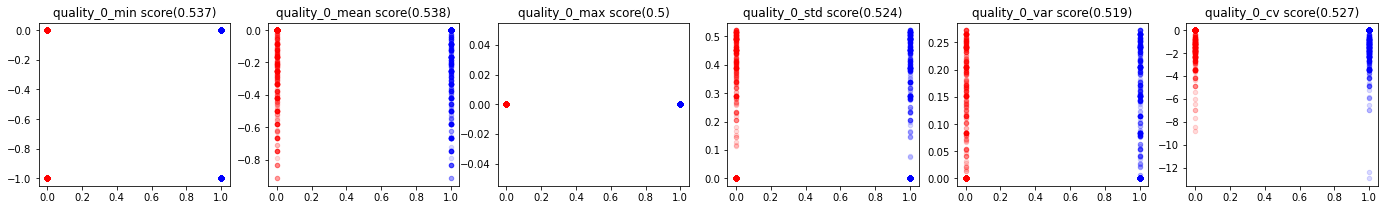

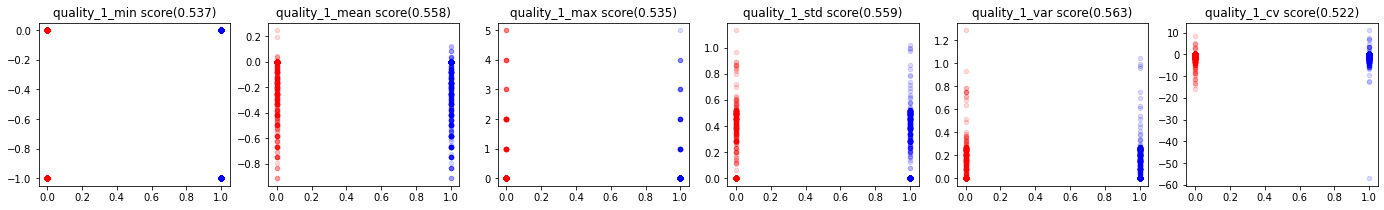

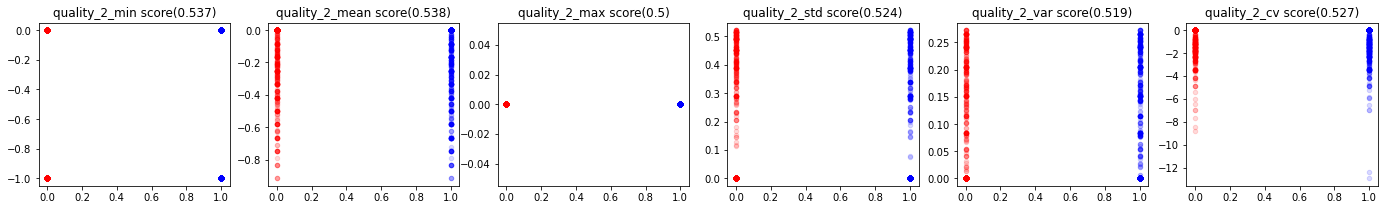

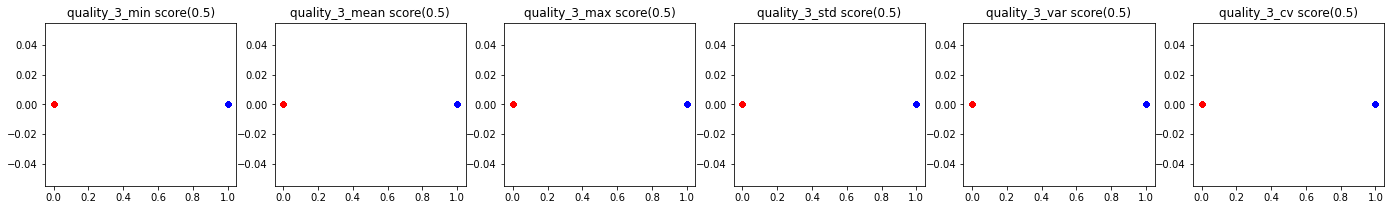

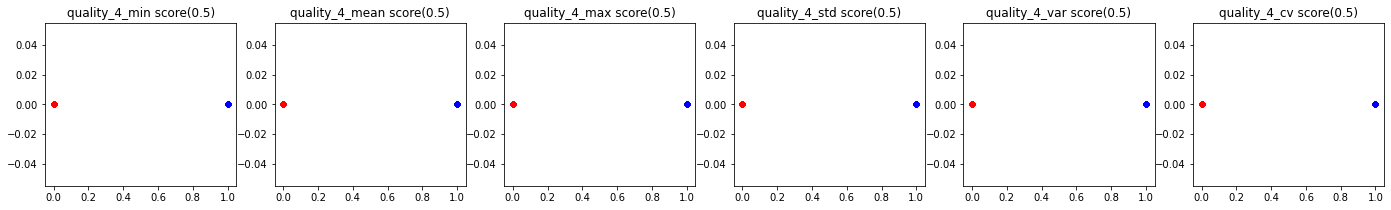

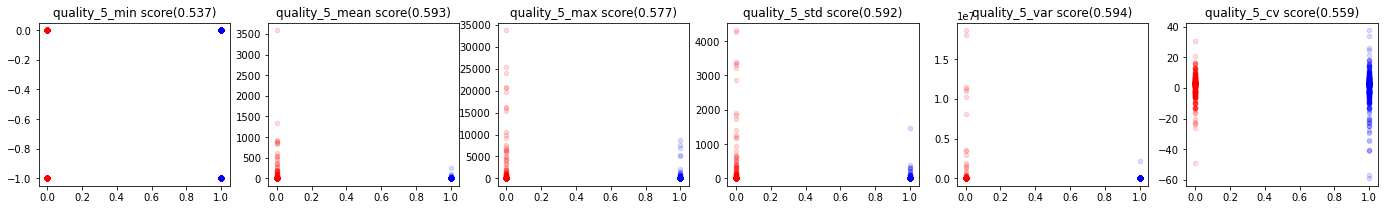

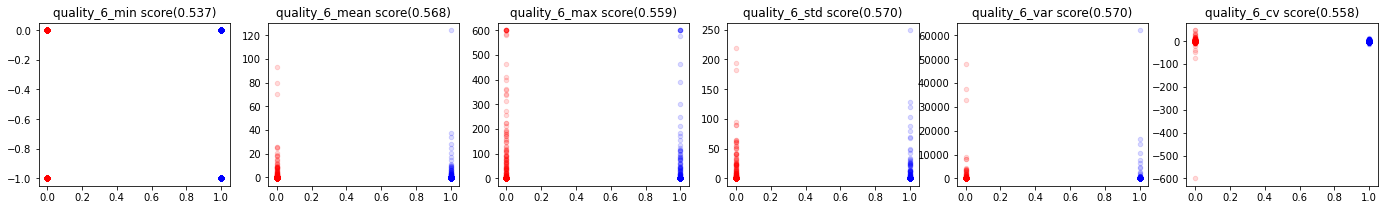

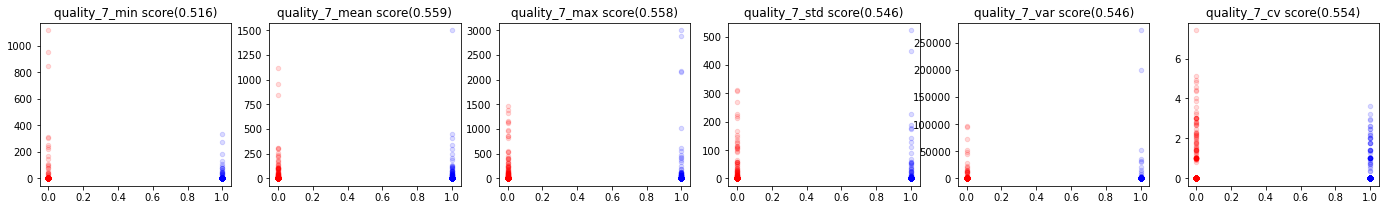

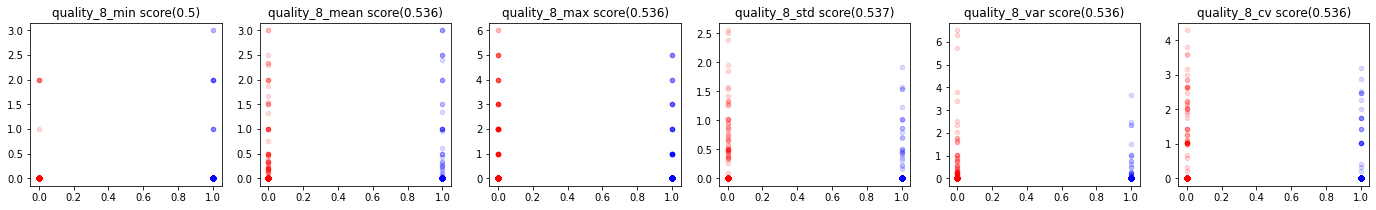

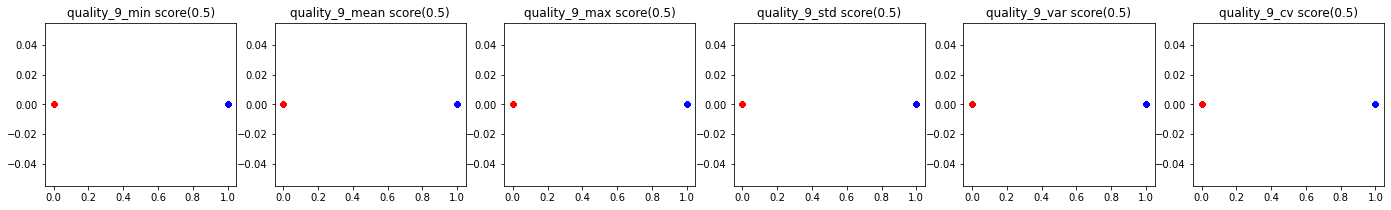

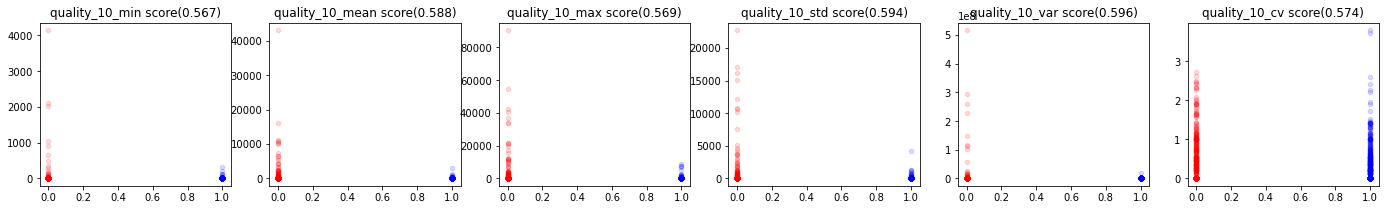

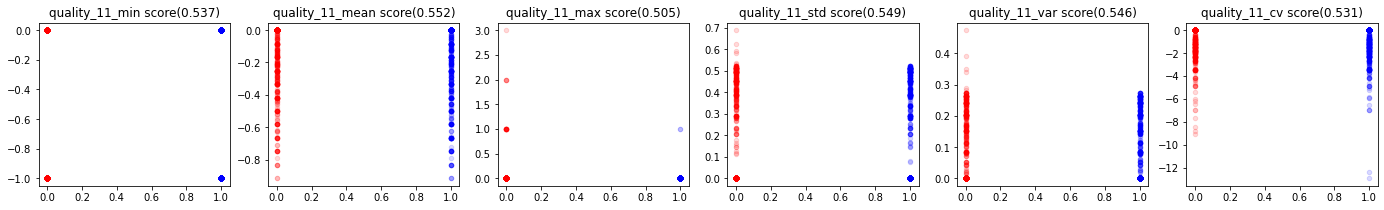

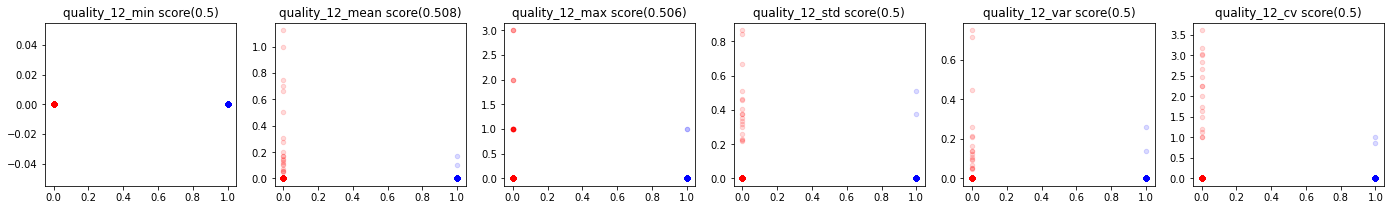

여기부터 04.22.1778


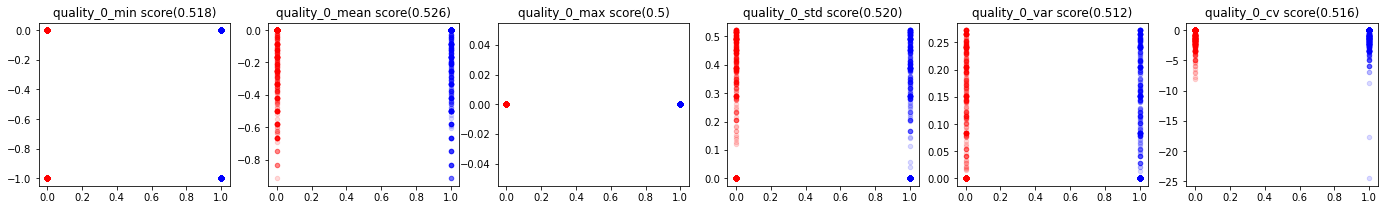

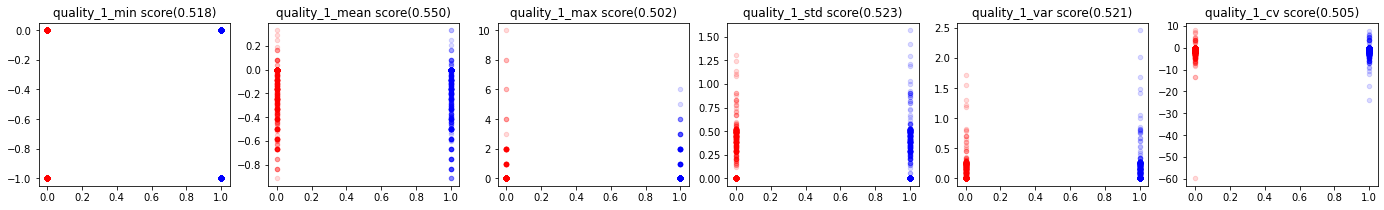

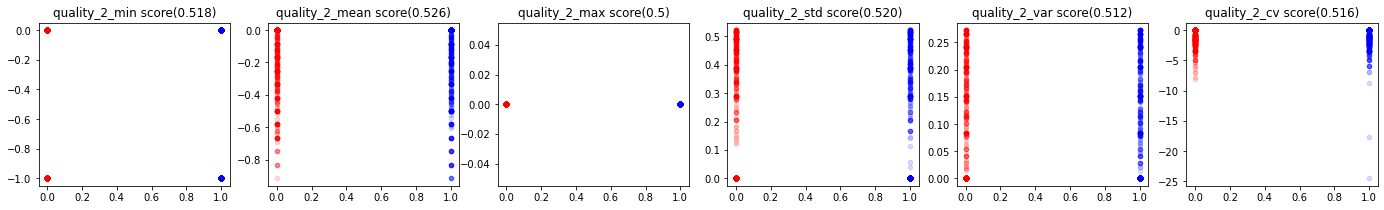

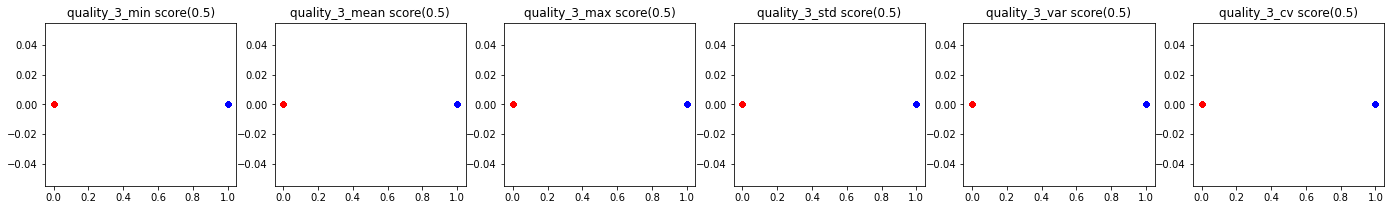

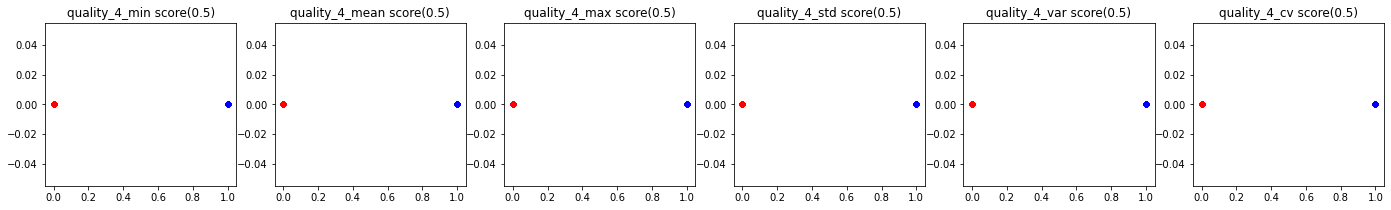

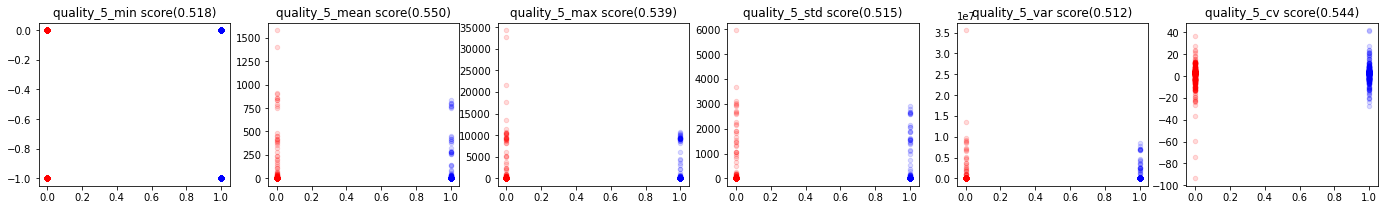

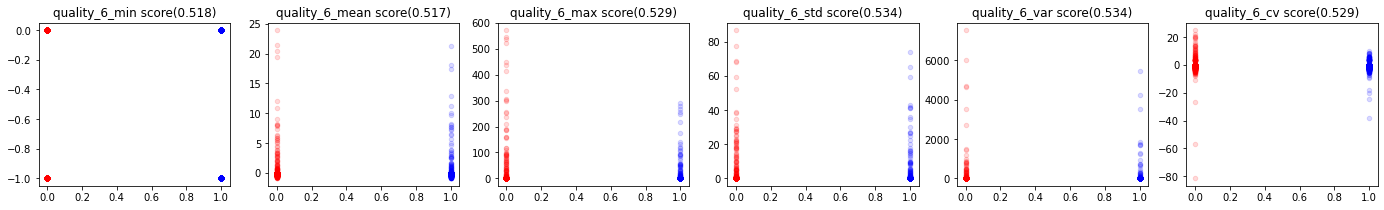

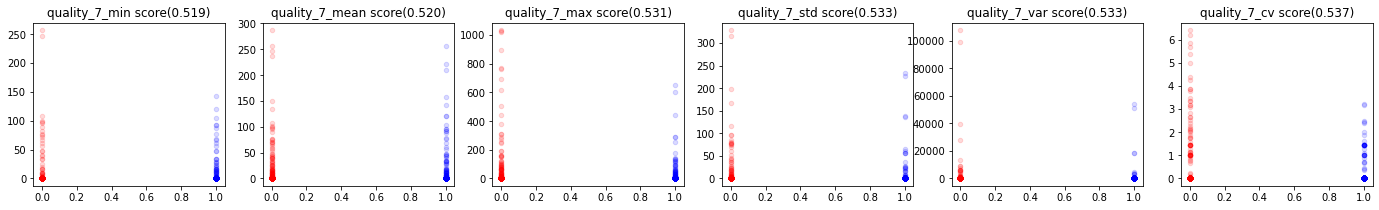

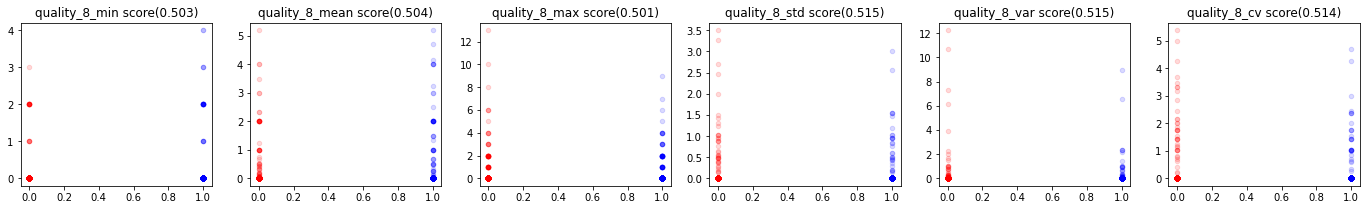

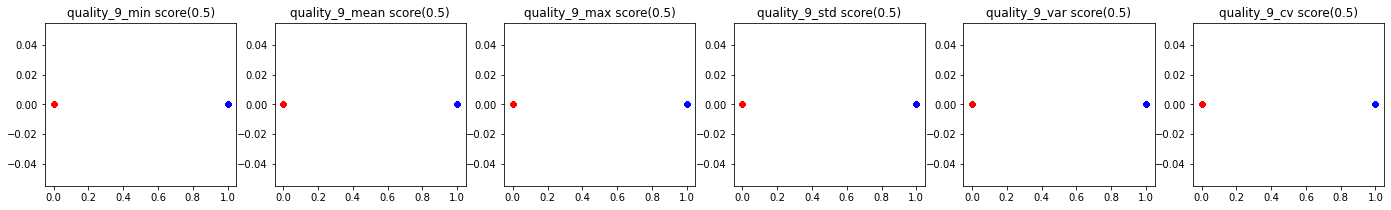

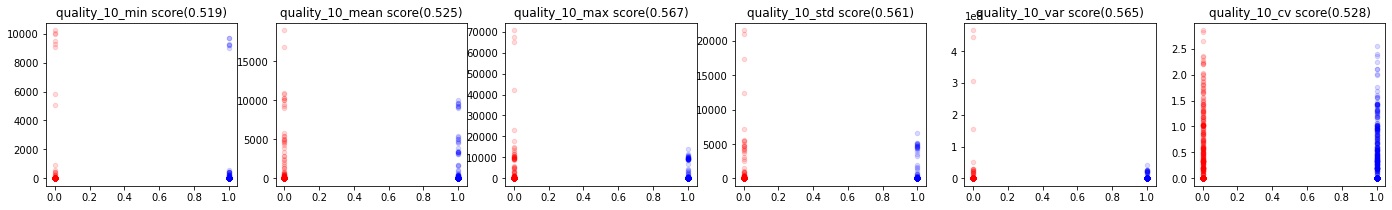

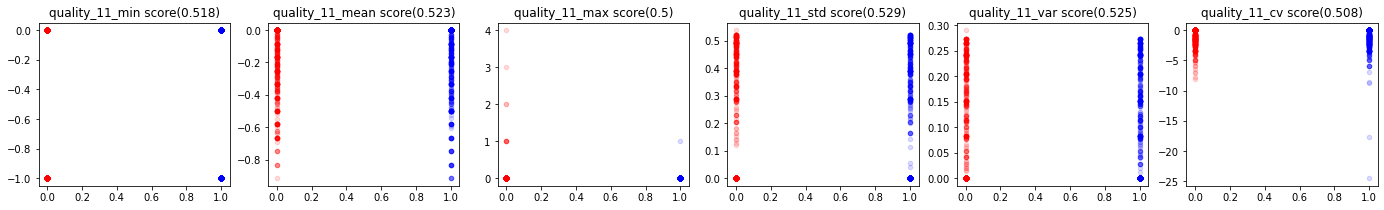

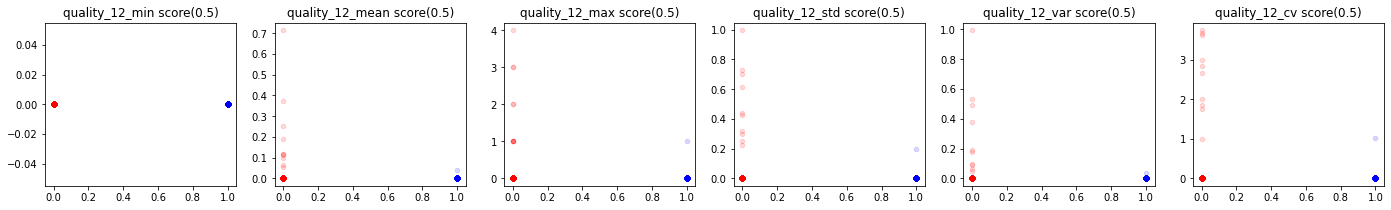

In [60]:
params = {
    'boosting_type' : 'gbdt',
    'objective'     : 'binary',
    'metric'        : 'auc',
    'verbose': -1,
    'seed': 1015
}
fwver_quality_importance = []
for fwver in ['05.15.2138', '04.22.1750', '04.33.1261', '04.16.3553', '03.11.1167', '04.33.1185', '04.22.1778']:
    print("여기부터 " + fwver)
    tq = train_quality[train_quality['fwver'] == fwver]
    for quality_no in range(0,13):
        plt.figure(figsize=(24,3))
        col = 'quality_' + str(quality_no)
        plt_data = {}
        for i in ['problem', 'no_problem']:
            plt_data[i] = {}
            for j in ['min','mean','max','std','var','cv']:
                plt_data[i][j] = []
                
        for user_id, group in tq.groupby('user_id'):
            is_problem = 'problem' if problem[user_id - 10000] == 1 else 'no_problem'
            plt_data[is_problem]['min'] += [group[col].min()]
            plt_data[is_problem]['mean'] += [group[col].mean()]
            plt_data[is_problem]['max'] += [group[col].max()]
            plt_data[is_problem]['std'] += [group[col].std()]
            plt_data[is_problem]['var'] += [group[col].var()]
            if (group[col].mean() == 0):
                plt_data[is_problem]['cv'] += [group[col].std()]
            else:
                plt_data[is_problem]['cv'] += [group[col].std() / group[col].mean()]
        
        # 가장 상위에 있는 두 점을 제거
        arrays = []
        for i in plt_data:
            for j in plt_data[i]:
                arrays.append(plt_data[i][j])
                
        for i in range(0,3):
            for arr in arrays:
                if (len(arr) >= 5):
                    index = arr.index(max(arr))
                    del(arr[index])
                
        for i, statistics in enumerate(plt_data['problem'].keys()):
            X = []
            y = []
            X += plt_data['problem'][statistics]
            y += [1] * len(plt_data['problem'][statistics])
            X += plt_data['no_problem'][statistics]
            y += [0] * len(plt_data['no_problem'][statistics])

            X_train = pd.DataFrame({'X': X, 'y':y})
            auc_scores = []
            folds = StratifiedKFold(10, random_state=42, shuffle=True)
            for train_idx, val_idx in folds.split(X_train[['X']], X_train['y']):
                d_train = lgb.Dataset(np.array(X_train['X'].iloc[train_idx]).reshape(-1, 1), 
                                       np.array(X_train['y'].iloc[train_idx]))
                d_val = lgb.Dataset(np.array(X_train['X'].iloc[val_idx]).reshape(-1, 1), 
                                       np.array(X_train['y'].iloc[val_idx]))
                gbm = lgb.train(params,
                                train_set=d_train, valid_sets=[d_train, d_val],
                                num_boost_round=1000000,
                                verbose_eval=False, early_stopping_rounds=100)
                auc_scores.append(roc_auc_score(X_train['y'].iloc[val_idx], gbm.predict(np.array(X_train['X'].iloc[val_idx]).reshape(-1, 1))))
    
    
            auc_score = np.array(auc_scores).mean()
            fwver_quality_importance.append([fwver, col, statistics, auc_score])
            plt.subplot(1, 6, i+1)
            plt.title(col + '_' + statistics + " score(" + str(auc_score)[:5] + ")")
            plt.scatter([0] * len(plt_data['problem'][statistics]), plt_data['problem'][statistics], linewidth=1, color="#ff000025", s=20)
            plt.scatter([1] * len(plt_data['no_problem'][statistics]), plt_data['no_problem'][statistics], linewidth=1, color="#0000ff25", s=20)
        plt.show()
fwver_quality_importance = pd.DataFrame(fwver_quality_importance, columns=['fwver','quality','statistics', 'auc_score'])

In [64]:
fwver_quality_importance.sort_values('auc_score', ascending=False).iloc[0:30]

,fwver,quality,statistics,auc_score
343,03.11.1167,quality_5,mean,0.634136
374,03.11.1167,quality_10,max,0.615000
349,03.11.1167,quality_6,mean,0.609102
382,03.11.1167,quality_11,var,0.607886
379,03.11.1167,quality_11,mean,0.602807
359,03.11.1167,quality_7,cv,0.600011
454,04.33.1185,quality_10,var,0.596501
363,03.11.1167,quality_8,std,0.595364
453,04.33.1185,quality_10,std,0.594812
351,03.11.1167,quality_6,std,0.594648


In [65]:
fwver_quality_importance.merge(result, on='fwver')

,fwver,quality,statistics,auc_score,train_count,train_count,all_count,problem users,no problem users,p/p+np
0,05.15.2138,quality_0,min,0.531516,163236,142704,305940,487,1237,0.282483
1,05.15.2138,quality_0,mean,0.555654,163236,142704,305940,487,1237,0.282483
2,05.15.2138,quality_0,max,0.521937,163236,142704,305940,487,1237,0.282483
3,05.15.2138,quality_0,std,0.534286,163236,142704,305940,487,1237,0.282483
4,05.15.2138,quality_0,var,0.542962,163236,142704,305940,487,1237,0.282483
...,...,...,...,...,...,...,...,...,...,...
541,04.22.1778,quality_12,mean,0.500000,56472,59736,116208,513,588,0.465940
542,04.22.1778,quality_12,max,0.500000,56472,59736,116208,513,588,0.465940
543,04.22.1778,quality_12,std,0.500000,56472,59736,116208,513,588,0.465940
544,04.22.1778,quality_12,var,0.500000,56472,59736,116208,513,588,0.465940
